In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Загружаем обучающую выборку
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/fmnist_train.csv')

In [4]:
# Загружаем тестовую выборку
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/fmnist_test.csv')

In [5]:
# Первичный анализ данных обучающей выборки
print("\nПервичный анализ обучающей выборки:")
print(train_df.head()) # Выводим несколько первых строк
print(train_df.info()) # Получаем общую информацию о DataFrame
print(train_df.describe()) # Получаем статистические сводки


Первичный анализ обучающей выборки:
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel776  pixel777  pixel778  pixel779  pixel780  pixel781  \
0       0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
1       0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
2       0  ...       0.0       0.0      30.0      43.0       0.0       0.0   
3       0  ...       0.0       0.0       0.0       0.0       1.0       0.0   
4       0  ...       0.0       0.0       0.0       0.0       0.0       0.0   

   pixel782  pixel783  pixel784  Id  

In [6]:
# Проверяем наличие NaN значений в обучающей выборке
print("\nПроверка на наличие NaN значений в обучающей выборке:")
print(train_df.isnull().sum().sum()) # Суммируем все NaN значения


Проверка на наличие NaN значений в обучающей выборке:
424


In [7]:
# Заполняем NaN значения медианным значением в обучающей выборке
train_df = train_df.fillna(train_df.median())
print("\nNaN значения в обучающей выборке заполнены медианным значением.")


NaN значения в обучающей выборке заполнены медианным значением.


In [8]:
# Проверяем наличие NaN значений в обучающей выборке после заполнения
print("\nПроверка на наличие NaN значений в обучающей выборке после заполнения:")
print(train_df.isnull().sum().sum())


Проверка на наличие NaN значений в обучающей выборке после заполнения:
0


In [9]:
# Первичный анализ данных тестовой выборки
print("\nПервичный анализ тестовой выборки:")
print(test_df.head()) # Выводим несколько первых строк
print(test_df.info()) # Получаем общую информацию о DataFrame
print(test_df.describe()) # Получаем статистические сводки


Первичный анализ тестовой выборки:
   pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0       0       0       0       0       0       0       0       9       8   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0      14      53      99   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel10  ...  pixel776  pixel777  pixel778  pixel779  pixel780  pixel781  \
0        0  ...        87        56         0         0         0         0   
1        0  ...         0         0         0         0         0         0   
2       17  ...         0         0         0        63        53        31   
3      161  ...       126       140         0       133       224       222   
4        0  ...         0         0         0         0         0         0   

   pixel782  pixel783  pix

In [10]:
# Проверяем наличие NaN значений в тестовой выборке
print("\nПроверка на наличие NaN значений в тестовой выборке:")
print(test_df.isnull().sum().sum()) # Суммируем все NaN значения


Проверка на наличие NaN значений в тестовой выборке:
0


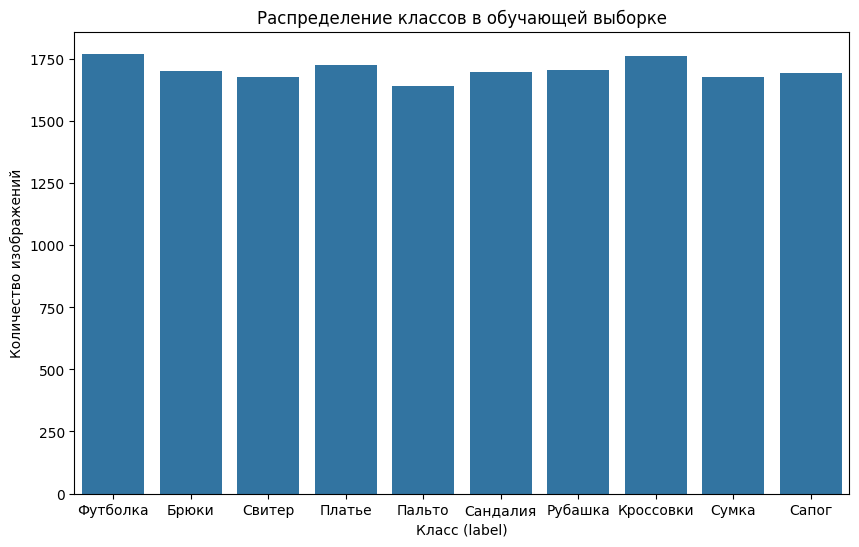

In [11]:
# Визуализация распределения классов в обучающей выборке
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_df)
plt.title('Распределение классов в обучающей выборке')
plt.xlabel('Класс (label)')
plt.ylabel('Количество изображений')
plt.xticks(ticks=range(10), labels=['Футболка', 'Брюки', 'Свитер', 'Платье', 'Пальто', 'Сандалия', 'Рубашка', 'Кроссовки', 'Сумка', 'Сапог'])
plt.show()

In [15]:
# Подготовка данных для обучения модели
# Отделяем признаки (пиксели) от целевой переменной (label) в обучающей выборке
X_train = train_df.drop(['label', 'Id'], axis=1)
y_train = train_df['label']

In [16]:
# Нормализуем значения пикселей к диапазону [0, 1]
X_train = X_train / 255.0

In [17]:
# Изменяем размерность данных для сверточной нейронной сети (CNN) - добавляем канал глубины
X_train = X_train.values.reshape(-1, 28, 28, 1)

In [18]:
# Преобразуем целевую переменную в категориальное представление (one-hot encoding)
num_classes = 10
y_train_encoded = to_categorical(y_train, num_classes)

In [19]:
# Разделяем обучающую выборку на тренировочную и валидационную части
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=42)

In [20]:
# Создаем модель сверточной нейронной сети (CNN)
model = Sequential([
    # Первый сверточный блок
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)), # 32 фильтра, ядро 3x3, функция активации ReLU
    MaxPooling2D((2, 2)), # Макс-пулинг для уменьшения размерности
    Dropout(0.25), # Dropout для предотвращения переобучения

    # Второй сверточный блок
    Conv2D(64, (3, 3), activation='relu'), # 64 фильтра, ядро 3x3, функция активации ReLU
    MaxPooling2D((2, 2)), # Макс-пулинг
    Dropout(0.25), # Dropout

    # Преобразование в плоский вектор для полносвязных слоев
    Flatten(),

    # Полносвязный слой
    Dense(128, activation='relu'), # 128 нейронов, функция активации ReLU
    Dropout(0.5), # Dropout

    # Выходной слой
    Dense(num_classes, activation='softmax') # 10 нейронов (по числу классов), функция активации Softmax
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Компилируем модель с более подходящими параметрами
model.compile(optimizer='adam', # Используем оптимизатор Adam
              loss='categorical_crossentropy', # Функция потерь для многоклассовой классификации
              metrics=['accuracy']) # Метрика для оценки - точность

# Early stopping для предотвращения переобучения
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce learning rate на плато
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# Обучаем модель с использованием Early Stopping и ReduceLROnPlateau
epochs = 50 # Увеличиваем количество эпох
batch_size = 64 # Увеличиваем размер батча
history = model.fit(X_train_split, y_train_split,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_split, y_val_split),
                    callbacks=[early_stopping, reduce_lr]) # Передаем колбэки

Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.5363 - loss: 1.3074 - val_accuracy: 0.7790 - val_loss: 0.5815 - learning_rate: 0.0010
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.7749 - loss: 0.6123 - val_accuracy: 0.8313 - val_loss: 0.4671 - learning_rate: 0.0010
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - accuracy: 0.8112 - loss: 0.5125 - val_accuracy: 0.8486 - val_loss: 0.4182 - learning_rate: 0.0010
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.8263 - loss: 0.4682 - val_accuracy: 0.8498 - val_loss: 0.4017 - learning_rate: 0.0010
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.8390 - loss: 0.4327 - val_accuracy: 0.8659 - val_loss: 0.3698 - learning_rate: 0.0010
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - accuracy: 0.8452 - loss: 0.4208 - val_accuracy: 0.8665 - val_loss: 0.3546 - learning_rate: 0.0010
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - accuracy: 0.8552 - 

In [22]:
# Оценка модели на валидационной выборке
val_loss, val_accuracy = model.evaluate(X_val_split, y_val_split, verbose=0)
print(f'\nТочность модели на валидационной выборке: {val_accuracy:.4f}')


Точность модели на валидационной выборке: 0.8982


In [23]:
# Выводим classification report для более детальной оценки
y_val_pred = model.predict(X_val_split)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val_split, axis=1)
print("\Отчет о классификации на валидационной выборке:\n", classification_report(y_val_true_classes, y_val_pred_classes))

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
\Отчет о классификации на валидационной выборке:
               precision    recall  f1-score   support

           0       0.84      0.85      0.84       324
           1       1.00      0.97      0.98       342
           2       0.85      0.87      0.86       361
           3       0.90      0.94      0.92       373
           4       0.80      0.86      0.83       310
           5       0.98      0.97      0.97       356
           6       0.75      0.67      0.71       340
           7       0.94      0.93      0.94       365
           8       1.00      0.97      0.98       328
           9       0.93      0.95      0.94       309

    accuracy                           0.90      3408
   macro avg       0.90      0.90      0.90      3408
weighted avg       0.90      0.90      0.90      3408



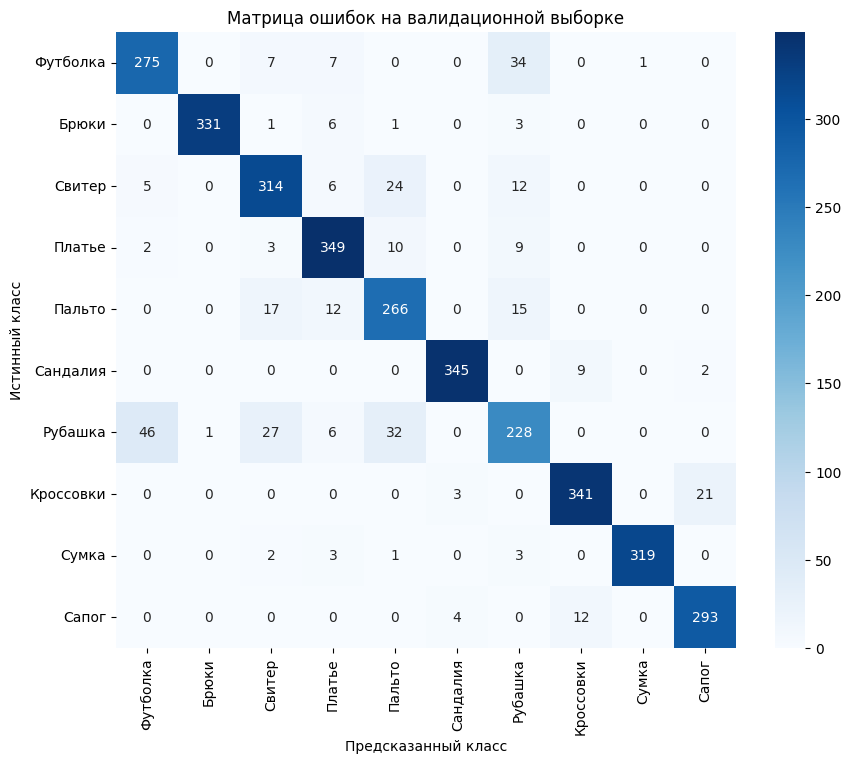

In [24]:
# Выводим confusion matrix
confusion_matrix_val = confusion_matrix(y_val_true_classes, y_val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Футболка', 'Брюки', 'Свитер', 'Платье', 'Пальто', 'Сандалия', 'Рубашка', 'Кроссовки', 'Сумка', 'Сапог'],
            yticklabels=['Футболка', 'Брюки', 'Свитер', 'Платье', 'Пальто', 'Сандалия', 'Рубашка', 'Кроссовки', 'Сумка', 'Сапог'])
plt.title('Матрица ошибок на валидационной выборке')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

In [26]:
# Подготовка тестовых данных
X_test = test_df.drop('Id', axis=1)
X_test = X_test / 255.0
X_test = X_test.values.reshape(-1, 28, 28, 1) # Изменяем размерность тестовых данных для CNN

In [27]:
# Получение предсказаний на тестовой выборке
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


In [33]:
# Создание файла submission
submission_df = pd.DataFrame({'Id': test_df['Id'], 'label': predicted_labels})
submission_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/submission.csv', index=False)

print("\nФайл submission.csv успешно создан.")


Файл submission.csv успешно создан.
